In [8]:
#import files and libraries
import os
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import random
import matplotlib.pyplot as plt


# Path to the dataset
# path = r"C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\r7bthvstxw-1"
path = "../datasets/r7bthvstxw-1"
import os

# Function to collect image paths and print picture counts in each directory
def images(path):
    found_images = []
    directory_counts = {}  # Dictionary to store counts for each directory

    for root, dirs, files in os.walk(path):
        count = 0  # Count images in the current directory
        for file in files:
            if file.endswith('.jpg'):
                found_images.append(os.path.join(root, file))
                count += 1
        if count > 0:  # Only include directories that have images
            directory_counts[root] = count

    # Print the count of images in each directory
    for directory, count in directory_counts.items():
        print(f"{directory}: {count} images")
    
    # Print total number of images
    print(f"Total images: {len(found_images)}")

    return found_images

# Path to the dataset directory
path = r"C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\r7bthvstxw-1"

# Get the list of images and print the counts
found_im = images(path)




C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\r7bthvstxw-1\hatchback: 181 images
C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\r7bthvstxw-1\motorcycle: 121 images
C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\r7bthvstxw-1\pickup: 478 images
C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\r7bthvstxw-1\sedan: 400 images
C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\r7bthvstxw-1\suv: 129 images
Total images: 1309


Need to augmentate pictures to expand dataset by rotating and doing things with the images

In [2]:
# Function to resize and augment images
def resize_and_augment_images(images, size, augment=True):
    processed_images = []
    for image in images:
        img = Image.open(image).convert('RGB')  # Greyscale
        img = img.resize((size, size))  # Resize to specified size
        
        if augment:  # Apply augmentation if enabled
            if random.random() > 0.5:  # Random rotation
                angle = random.randint(-30, 30)  # Rotate between -30 and 30 degrees
                img = img.rotate(angle)
            
            if random.random() > 0.5:  # Horizontal flip
                img = ImageOps.mirror(img)
            
            if random.random() > 0.5:  # Brightness adjustment
                enhancer = ImageEnhance.Brightness(img)
                factor = random.uniform(0.8, 1.2)  # Adjust brightness between 80% and 120%
                img = enhancer.enhance(factor)
            
            if random.random() > 0.5:  # Adding noise
                img = np.array(img)
                noise = np.random.normal(0, 0.05, img.shape)  # Add Gaussian noise
                img = np.clip(img + noise, 0, 1)  # Ensure pixel values remain in [0, 1]
                img = Image.fromarray((img * 255).astype(np.uint8))
        
        img = np.array(img) / 255.0  # Normalize to [0, 1]
        processed_images.append(img)
    
    return np.array(processed_images)

# Usage
processed_images = resize_and_augment_images(found_im, 128, augment=True)


In [3]:
import random
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
from collections import Counter

# Function to resize, augment, and balance images
def resize_augment_and_balance(images, labels, size=128, augment=True):
    processed_images = []
    processed_labels = []
    
    # Count the number of images per class
    label_counts = Counter(labels)
    max_count = max(label_counts.values())  # Find the maximum class count

    # Group images by class
    class_images = {label: [] for label in label_counts}
    for image, label in zip(images, labels):
        class_images[label].append(image)

    # Augment images from minority classes to balance the dataset
    for label, image_paths in class_images.items():
        current_count = label_counts[label]
        num_to_add = max_count - current_count
        
        # Add existing images to processed list
        for image_path in image_paths:
            img = process_image(image_path, size, augment)
            processed_images.append(img)
            processed_labels.append(label)
        
        # Augment additional images for balancing
        if num_to_add > 0:
            for _ in range(num_to_add):
                img_path = random.choice(image_paths)  # Randomly pick an existing image
                img = process_image(img_path, size, augment=True)  # Always augment for new samples
                processed_images.append(img)
                processed_labels.append(label)

    return np.array(processed_images), np.array(processed_labels)

# Helper function to process and augment a single image
def process_image(image_path, size, augment=True):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB
    img = img.resize((size, size))  # Resize to specified size

    if augment:
        if random.random() > 0.5:  # Random rotation
            angle = random.randint(-30, 30)  # Rotate between -30 and 30 degrees
            img = img.rotate(angle)

        if random.random() > 0.5:  # Horizontal flip
            img = ImageOps.mirror(img)

        if random.random() > 0.5:  # Brightness adjustment
            enhancer = ImageEnhance.Brightness(img)
            factor = random.uniform(0.8, 1.2)  # Adjust brightness between 80% and 120%
            img = enhancer.enhance(factor)

        if random.random() > 0.5:  # Adding noise
            img = np.array(img)
            noise = np.random.normal(0, 0.05, img.shape)  # Add Gaussian noise
            img = np.clip(img + noise, 0, 1)  # Ensure pixel values remain in [0, 1]
            img = Image.fromarray((img * 255).astype(np.uint8))
    
    img = np.array(img) / 255.0  # Normalize to [0, 1]
    return img

# Usage Example
# Assuming `found_im` contains image paths and `labels` contains their corresponding labels
processed_images, processed_labels = resize_augment_and_balance(found_im, labels, size=128, augment=True)
print(f"Processed images shape: {processed_images.shape}")
print(f"Balanced label distribution: {Counter(processed_labels)}")


Processed images shape: (2390, 128, 128, 3)
Balanced label distribution: Counter({'hatchback': 478, 'motorcycle': 478, 'pickup': 478, 'sedan': 478, 'suv': 478})


In [57]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Assuming resize_augment_and_balance has already been run
processed_images, processed_labels = resize_augment_and_balance(found_im, labels, size=128, augment=True)

# Check the updated label distribution
print(Counter(processed_labels))  # Ensure labels are balanced

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    processed_images, processed_labels, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Counter({'hatchback': 478, 'motorcycle': 478, 'pickup': 478, 'sedan': 478, 'suv': 478})
Training size: 1673, Validation size: 358, Test size: 359


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import numpy as np

# Load a pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Create a feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from processed images
# Ensure processed_images are normalized and reshaped to (N, 128, 128, 3)
features_train = feature_extractor.predict(np.stack(X_train, axis=0))
features_val = feature_extractor.predict(np.stack(X_val, axis=0))
features_test = feature_extractor.predict(np.stack(X_test, axis=0))

print(f"Extracted train features shape: {features_train.shape}")  # Example: (N, 4, 4, 2048)


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step
Extracted train features shape: (1673, 4, 4, 2048)


In [5]:
# Flatten the extracted features
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_val_flat = features_val.reshape(features_val.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)

print(f"Flattened train features shape: {features_train_flat.shape}")  # Example: (N, 32768)


Flattened train features shape: (1673, 32768)


In [6]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Retain 100 principal components
features_train_pca = pca.fit_transform(features_train_flat)
features_val_pca = pca.transform(features_val_flat)
features_test_pca = pca.transform(features_test_flat)

print(f"Reduced train features shape: {features_train_pca.shape}")  # Example: (N, 100)


Reduced train features shape: (1673, 100)


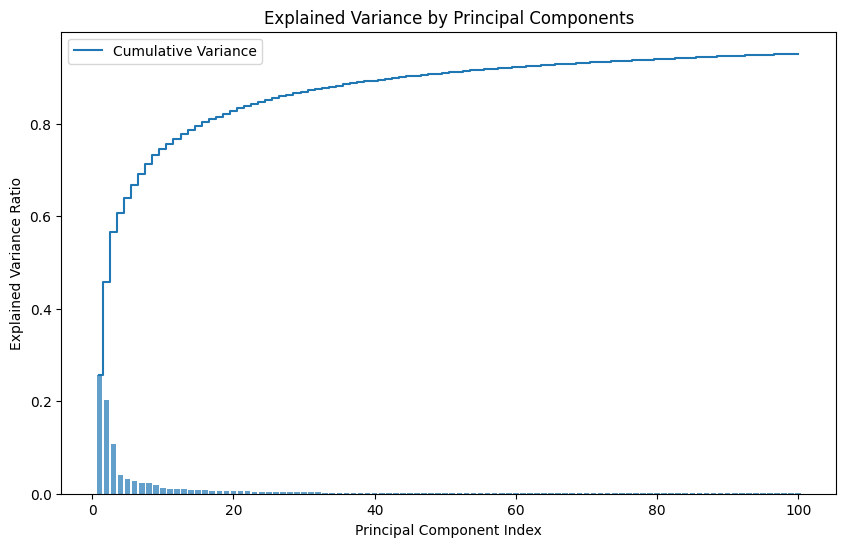

In [61]:
import matplotlib.pyplot as plt
# Fit PCA and calculate explained variance
pca = PCA(n_components=100)  # Limit to 10 components for visualization
pca.fit(features_train_flat)
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()
